# M1 - Decision Tree Classifier (all features)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import xgboost as xgb

from hyperopt import hp, tpe, Trials, fmin
from hyperopt.pyll.base import scope
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.pipeline import Pipeline
from joblib import dump

## Loading Dataset

In [2]:
#INPUT AND OUTPUT LOCATION FOLDER 
location = '/Users/klaaskorteweg/Desktop/Master Thesis/'

train = 'train_data_processed.xlsx'
test = 'test_data_processed.xlsx'

train_df = pd.read_excel(location+train)
test_df = pd.read_excel(location+test)

In [3]:
train_df.drop(columns=['date'], inplace=True)
train_df = train_df.astype(str)

test_df.drop(columns=['date'], inplace=True)
test_df = test_df.astype(str)

print(train_df.columns.tolist())

['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate', 'city', 'attacktype1_txt', 'targtype1_txt', 'gname', 'gsubname', 'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3', 'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday', 'quarter', 'weekend']


## Settings

In [4]:
#NAME AND CLASSIFIER ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
name = "Decision Tree Classifier (all features)"
classifier = DecisionTreeClassifier()

#TARGET AND FEATURES ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
target = 'targtype1_txt'
variables = ['iyear', 'imonth', 'iday', 'country_txt', 'region_txt', 'provstate',
       'city', 'attacktype1_txt', 'gname', 'gsubname',
       'weaptype1_txt', 'weapsubtype1_txt', 'crit1', 'crit2', 'crit3',
       'multiple', 'suicide', 'individual', 'INT_MISC', 'weekday',
       'quarter', 'weekend']

#FEATURE SELECTION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
selector = SelectKBest(score_func=chi2, k='all')

# TIME SERIES CROSS VALIDATION ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
k_time_series_splits = 5

#HYPERPARAMETER TUNING ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
evals = 40

space = {
    'classifier__criterion': hp.choice('classifier__criterion', ['gini', 'entropy', 'log_loss']),
    'classifier__splitter': hp.choice('classifier__splitter', ['best', 'random']),
    'classifier__max_depth': scope.int(hp.quniform('classifier__max_depth', 3, 30, 2)),
    'classifier__min_samples_split': scope.int(hp.quniform('classifier__min_samples_split', 2, 20, 2)),
    'classifier__min_samples_leaf': scope.int(hp.quniform('classifier__min_samples_leaf', 2, 20, 2)),
    'classifier__max_features': hp.choice('classifier__max_features', [None, 'sqrt', 'log2'])
}
# !!! Also adjust the best_parameters according to the hyperparameter search space !!!

## Time Series Cross Validation Split

In [5]:
print("Number of splits:",k_time_series_splits)

tscv = TimeSeriesSplit(n_splits=k_time_series_splits) 

for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    print(f"Split {i}")
    print(f"Train: index={train_index}")
    print(f"Validation: index={val_index}")

Number of splits: 5
Split 0
Train: index=[    0     1     2 ... 27178 27179 27180]
Validation: index=[27181 27182 27183 ... 54354 54355 54356]
Split 1
Train: index=[    0     1     2 ... 54354 54355 54356]
Validation: index=[54357 54358 54359 ... 81530 81531 81532]
Split 2
Train: index=[    0     1     2 ... 81530 81531 81532]
Validation: index=[ 81533  81534  81535 ... 108706 108707 108708]
Split 3
Train: index=[     0      1      2 ... 108706 108707 108708]
Validation: index=[108709 108710 108711 ... 135882 135883 135884]
Split 4
Train: index=[     0      1      2 ... 135882 135883 135884]
Validation: index=[135885 135886 135887 ... 163058 163059 163060]


## Encoding & Pipeline

In [6]:
#Seperating variables and target for train and testing set
X_train = train_df[variables]
y_train = train_df[target]
X_test = test_df[variables]
y_test = test_df[target]

#Encoding target variable for train and testing set
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#Encoding features for pipeline 
preprocessor = ColumnTransformer(
    transformers=[
        ('encoder', OneHotEncoder(handle_unknown='ignore'), variables)
        ],
    remainder='drop'
)

#Pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector',selector),
    ('classifier', classifier) 
    ])

## Hyperparameter Tuning
Hyperopt with Bayesian optimization

In [7]:
def objective(params):
    pipeline.set_params(**params)
    scores = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
    return -scores.mean()  

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=evals, trials=trials)

print("Best hyperparameters:", best)


100%|██████████| 40/40 [05:06<00:00,  7.67s/trial, best loss: -0.45532087135707977]
Best hyperparameters: {'classifier__criterion': 0, 'classifier__max_depth': 18.0, 'classifier__max_features': 0, 'classifier__min_samples_leaf': 2.0, 'classifier__min_samples_split': 2.0, 'classifier__splitter': 0}


In [8]:
best_params = {
    'classifier__criterion': ['gini', 'entropy', 'log_loss'][int(best['classifier__criterion'])],
    'classifier__splitter': ['best', 'random'][int(best['classifier__splitter'])],
    'classifier__max_depth': int(best['classifier__max_depth']),
    'classifier__min_samples_split': int(best['classifier__min_samples_split']),
    'classifier__min_samples_leaf': int(best['classifier__min_samples_leaf']),
    'classifier__max_features': [None, 'sqrt', 'log2'][int(best['classifier__max_features'])]
}

print(best_params)

pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train_encoded)

{'classifier__criterion': 'gini', 'classifier__splitter': 'best', 'classifier__max_depth': 18, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_features': None}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['iyear', 'imonth', 'iday',
                                                   'country_txt', 'region_txt',
                                                   'provstate', 'city',
                                                   'attacktype1_txt', 'gname',
                                                   'gsubname', 'weaptype1_txt',
                                                   'weapsubtype1_txt', 'crit1',
                                                   'crit2', 'crit3', 'multiple',
                                                   'suicide', 'individual',
                                                   'INT_MISC', 'weekday',
                                                   'quarter', 'weekend'])])),
                ('selector',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x13dd6b420>)),
                ('classifier',
                 DecisionTreeClassifier(max_depth=18, min_samples_leaf=2))])

In [9]:
cv_scores_after_opt = cross_val_score(pipeline, X_train, y_train_encoded, cv=tscv, scoring='accuracy')
print("Tuned Model ({}):".format(name))
print("Cross-validation scores (best param.):", cv_scores_after_opt)
print("Mean CV score (best param.):", cv_scores_after_opt.mean())

Tuned Model (Decision Tree Classifier (all features)):
Cross-validation scores (best param.): [0.4739108  0.38169709 0.40649838 0.47449956 0.539005  ]
Mean CV score (best param.): 0.4551221666176038


In [10]:
opt_test_accuracy = pipeline.score(X_test, y_test_encoded)
opt_train_accuracy = pipeline.score(X_train, y_train_encoded)

opt_train_predictions = pipeline.predict(X_train)
opt_test_predictions = pipeline.predict(X_test)

print("Tuned Model ({}):".format(name))
print("Train accuracy",opt_train_accuracy)
print("Test accuracy",opt_test_accuracy)


Tuned Model (Decision Tree Classifier (all features)):
Train accuracy 0.5799302101667474
Test accuracy 0.5590940183932508


## Summary

In [11]:
print(name)
print()
print("Time Series Split:")
print('- Number of splits:',k_time_series_splits)
print('- Split Indices:')
split_info = {}
for i, (train_index, val_index) in enumerate(tscv.split(train_df)):
    split_info[f"Split {i}"] = {'Train': f"{train_index[0]}-{train_index[-1]}", 'Val': f"{val_index[0]}-{val_index[-1]}"}
print(" ",split_info)
print()

print("Hyperparameter Tuning:")
print("- Parameter Grid:",space)
print("- Best Parameters:",best_params)

print()
print("Tuned Model:")
print("- TSCV scores (best param.):", cv_scores_after_opt)
print("- Mean TSCV score (best param.):", cv_scores_after_opt.mean())
print("- Training set accuracy:", opt_train_accuracy)
print("- Testing set accuracy:",opt_test_accuracy)


Decision Tree Classifier (all features)

Time Series Split:
- Number of splits: 5
- Split Indices:
  {'Split 0': {'Train': '0-27180', 'Val': '27181-54356'}, 'Split 1': {'Train': '0-54356', 'Val': '54357-81532'}, 'Split 2': {'Train': '0-81532', 'Val': '81533-108708'}, 'Split 3': {'Train': '0-108708', 'Val': '108709-135884'}, 'Split 4': {'Train': '0-135884', 'Val': '135885-163060'}}

Hyperparameter Tuning:
- Parameter Grid: {'classifier__criterion': <hyperopt.pyll.base.Apply object at 0x15ed46350>, 'classifier__splitter': <hyperopt.pyll.base.Apply object at 0x15ed46790>, 'classifier__max_depth': <hyperopt.pyll.base.Apply object at 0x15ed46c90>, 'classifier__min_samples_split': <hyperopt.pyll.base.Apply object at 0x15ed47190>, 'classifier__min_samples_leaf': <hyperopt.pyll.base.Apply object at 0x15ed47690>, 'classifier__max_features': <hyperopt.pyll.base.Apply object at 0x15ed47b50>}
- Best Parameters: {'classifier__criterion': 'gini', 'classifier__splitter': 'best', 'classifier__max_dept

## Error checks

In [12]:
def check_encoding(Y_train, Y_train_encoded, Y_test, Y_test_encoded):
    train_label_map = {val: label for val, label in zip(Y_train_encoded, Y_train)}
    test_label_map = {val: label for val, label in zip(Y_test_encoded, Y_test)}

    for val in set(Y_train_encoded) | set(Y_test_encoded):
        train_label = train_label_map.get(val)
        test_label = test_label_map.get(val)

        if train_label is None:
            print(f"Value {val} is present in test set but not in train set.")
        elif test_label is None:
            print(f"Value {val} is present in train set but not in test set.")
        elif train_label == test_label:
            print(f"Value {val}: {train_label} == {test_label} -- Check")
        else:
            print(f"Value {val}: {train_label} != {test_label} -- NOT EQUAL")


check_encoding(y_train, y_train_encoded, y_test, y_test_encoded)

Value 0: Business == Business -- Check
Value 1: Government (General) == Government (General) -- Check
Value 2: Military == Military -- Check
Value 3: Other == Other -- Check
Value 4: Police == Police -- Check
Value 5: Private Citizens & Property == Private Citizens & Property -- Check


## Error Analysis

[[ 8509  1056    28  5352  1497  3290]
 [ 2960  7997    25  3541  2270  3317]
 [  280   405 21197  1077   955  1134]
 [ 4040  2428   179 21598  2985  4804]
 [ 1450  2045   143  3177 11266  4488]
 [ 2623  2545   159  5800  4444 23997]]


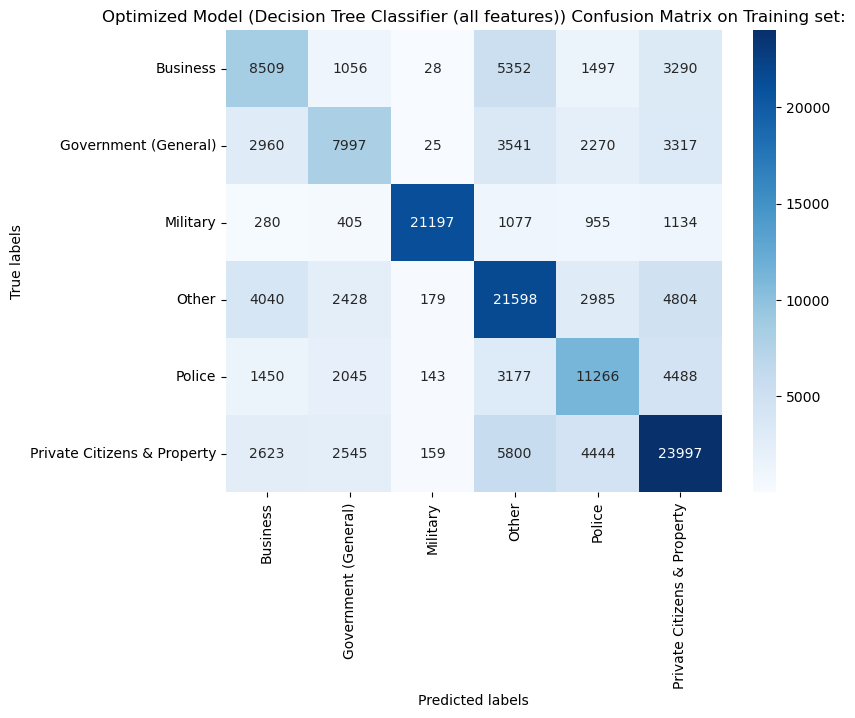

In [13]:

cm = confusion_matrix(y_train_encoded, opt_train_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Training set:".format(name))
plt.show()

[[ 290  158   27  767  368  827]
 [ 111 1497   21  630  596  863]
 [  35  152 7881  225  339  451]
 [ 335  616   77 2359  928 1502]
 [  94  520  129  771 2845 1640]
 [ 328  915  155 1680 2143 7196]]


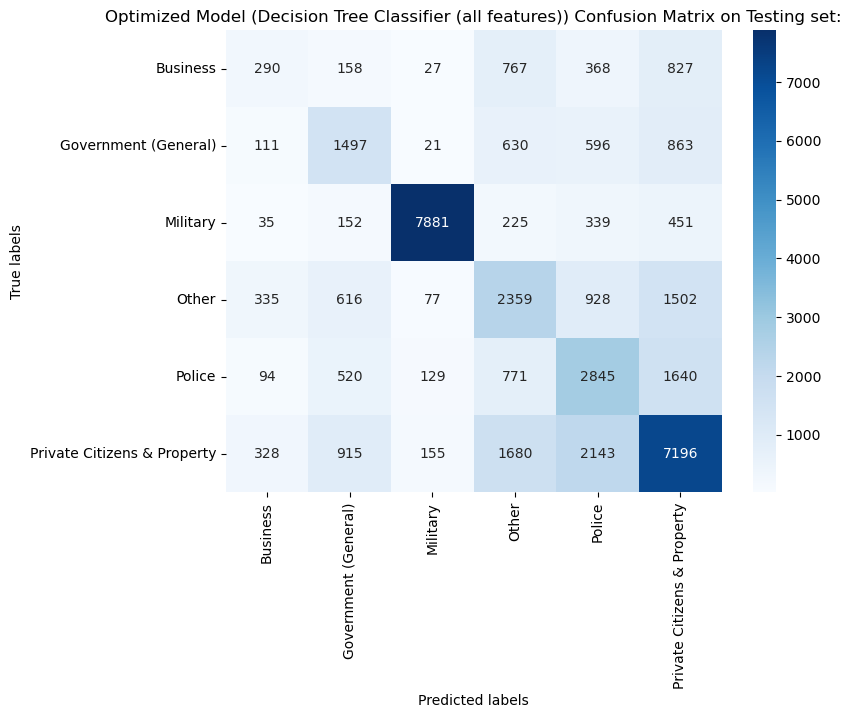

In [14]:

cm = confusion_matrix(y_test_encoded, opt_test_predictions)
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title("Optimized Model ({}) Confusion Matrix on Testing set:".format(name))
plt.show()

In [15]:
train_report = classification_report(y_train_encoded, opt_train_predictions)
print("Optimized Model ({}) Classification Report on Training set:".format(name))
print(train_report)

test_report = classification_report(y_test_encoded, opt_test_predictions)
print("Optimized Model ({}) Classification Report on Testing set:".format(name))
print(test_report)

Optimized Model (Decision Tree Classifier (all features)) Classification Report on Training set:
              precision    recall  f1-score   support

           0       0.43      0.43      0.43     19732
           1       0.49      0.40      0.44     20110
           2       0.98      0.85      0.91     25048
           3       0.53      0.60      0.56     36034
           4       0.48      0.50      0.49     22569
           5       0.58      0.61      0.60     39568

    accuracy                           0.58    163061
   macro avg       0.58      0.56      0.57    163061
weighted avg       0.59      0.58      0.58    163061

Optimized Model (Decision Tree Classifier (all features)) Classification Report on Testing set:
              precision    recall  f1-score   support

           0       0.24      0.12      0.16      2437
           1       0.39      0.40      0.40      3718
           2       0.95      0.87      0.91      9083
           3       0.37      0.41      0.39    

## Save Pipeline

In [16]:
filename = name + '.joblib'

dump(pipeline, filename)

['Decision Tree Classifier (all features).joblib']

## Feature Importance Analysis

In [17]:
try:
    feature_importances = pipeline.named_steps['classifier'].feature_importances_
    feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()


    feature_names = [name.split('_', 2)[-1] for name in feature_names]

    sorted_importances = sorted(zip(feature_names, feature_importances), key=lambda x: x[1], reverse=True)

    print("Feature Importances:")
    for feature_name, importance in sorted_importances:
        print(f"{feature_name}: {importance}")
except AttributeError:
    
    raise ValueError("Feature importances are not available for the chosen classifier.")


Feature Importances:
crit3_1: 0.4063649080248426
region_txt_Middle East & North Africa: 0.022430585112238877
attacktype1_txt_Assassination: 0.0198107482370539
attacktype1_txt_Armed Assault: 0.019672196507172664
INT_MISC_1: 0.01821226074909271
INT_MISC_0: 0.016548811978214565
city_Other: 0.012015984434507933
region_txt_South Asia: 0.011460335556302235
region_txt_Sub-Saharan Africa: 0.01108834005901732
weapsubtype1_txt_Projectile (rockets, mortars, RPGs, etc.): 0.010545972106762223
attacktype1_txt_Hostage Taking (Kidnapping): 0.009208779109236568
provstate_northern ireland: 0.00918630215954285
weapsubtype1_txt_Unknown Explosive Type: 0.009033820074404328
gname_Unknown: 0.008700906407127522
crit2_1: 0.008368465482773525
attacktype1_txt_Facility/Infrastructure Attack: 0.008104116206457141
gname_Farabundo Marti National Liberation Front (FMLN): 0.007193610848000041
attacktype1_txt_Bombing/Explosion: 0.00714086032031742
multiple_0: 0.0069386218569564674
country_txt_Iraq: 0.006454375000523762

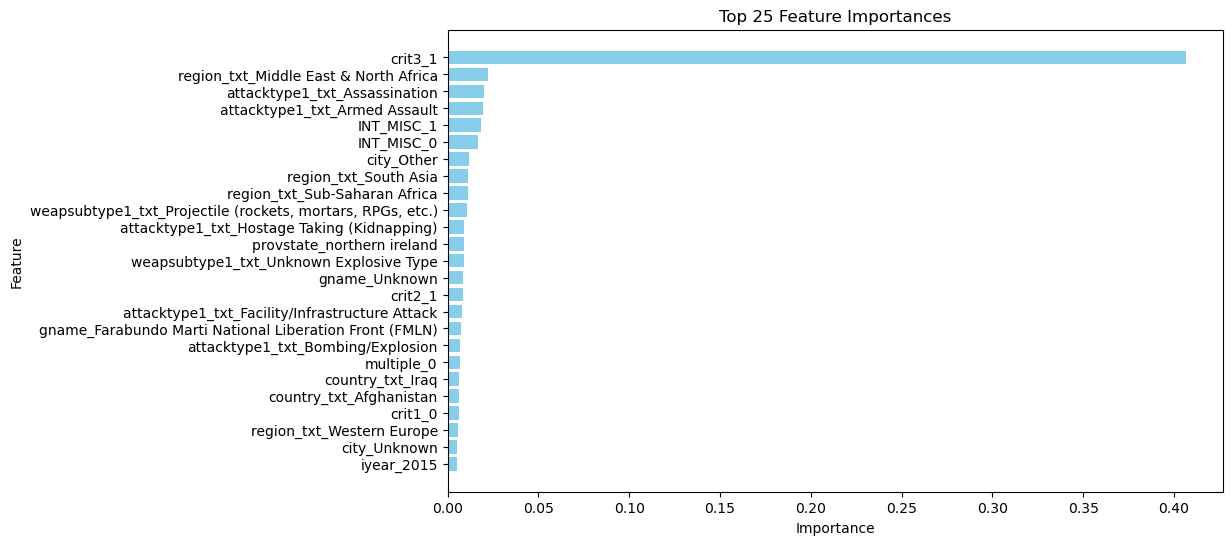

In [18]:

top_features_count = 25


top_features = [feature_name for feature_name, _ in sorted_importances[:top_features_count]]
top_importances = [importance for _, importance in sorted_importances[:top_features_count]]


plt.figure(figsize=(10, 6))
plt.barh(top_features, top_importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top {top_features_count} Feature Importances')
plt.gca().invert_yaxis()  
plt.show()


## Hyperparameter Graph

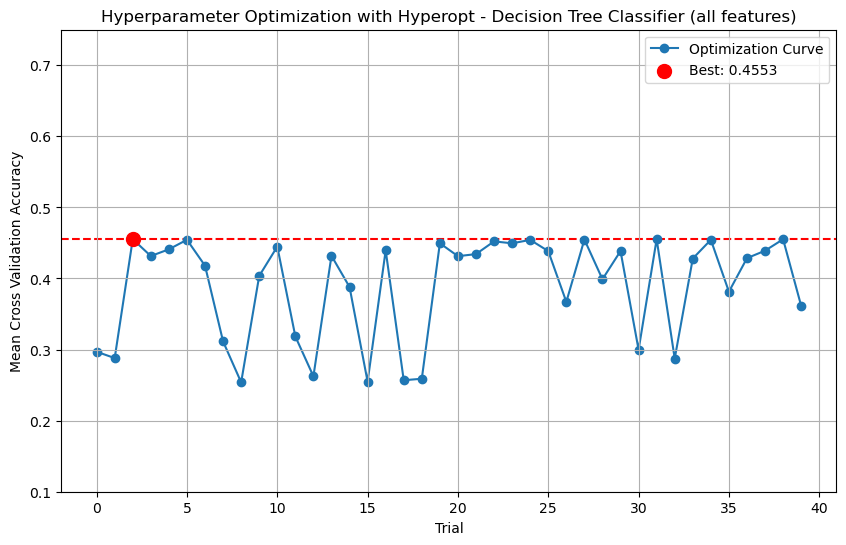

In [19]:
import matplotlib.pyplot as plt

losses = [-trial['result']['loss'] for trial in trials.trials]


plt.figure(figsize=(10, 6))
plt.plot(losses, marker='o', linestyle='-', label='Optimization Curve', zorder=1)  
plt.xlabel('Trial')
plt.ylabel('Mean Cross Validation Accuracy')
plt.title(f'Hyperparameter Optimization with Hyperopt - {name}')
plt.grid(True)

plt.ylim(0.1, 0.75)


best_iteration = len(losses) - 1 - losses[::-1].index(max(losses))  
best_loss = max(losses)


plt.scatter([best_iteration], [best_loss], color='red', label=f'Best: {best_loss:.4f}', s=100, marker='o', zorder=2)  # Higher zorder to plot in front


plt.axhline(y=best_loss, color='red', linestyle='--', zorder=0)  

plt.legend()

plt.show()